# one-step delta learning rule

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

from scipy.stats import zscore

In [3]:
## human data
import pandas as pd
humandf = pd.read_csv('humandf.csv')
humanB = humandf.loc[:,'blocked mean'].values
humanI = humandf.loc[:,'interleaved mean'].values
# acc and normalized
human_acc = np.stack([humanB,humanI])
zacc_human = zscore(human_acc,axis=1) 

### free params:
- sticky_decay_rate = 0.025
- pe_thresh = 1
- init_lr = 0.3
- lr_decay_rate = 0.1


In [ ]:
nsubs = 50
task = Task()
condL = ['blocked','interleaved']
ntr,nte = 160,40

def run_exp(nsubs,condL,ntr,nte,paramD):
    print('N=%i'%nsubs,paramD)
    accL = [[],[]]
    for ci,cond in enumerate(condL):
        for s in range(nsubs):
            ag = Agent(**paramD)
            exp,cur = task.generate_experiment(cond,ntr,nte)
            acc,pe = ag.forward_exp(exp) 
            accL[ci].append(acc)
    acc = np.array(accL)
    return acc

def calc_fit(paramD):
    """ 
    calcualte mean squared error for model fit
    returns mse per condition
    """
    acc = run_exp(nsubs,condL,ntr,nte,paramD)
    zacc_model = zscore(acc,axis=2).mean(1)[:,:,1] 
    # zacc_model.shape == 2,200 # cond,time
    MSE = np.sum((zacc_human - zacc_model)**2,1)
    return MSE
  
Sd = [0.025]
Pt = np.arange(0.8,1.21,0.1)
L0 = np.arange(0.25,0.351,0.05)
Ld = np.arange(0.05,0.151,0.05)


mseL = []
paramL = []
for sd,pt,l0,ld in itertools.product(Sd,Pt,L0,Ld):
    paramD = {
      'sticky_decay_rate':sd,
      'pe_thresh':pt,
      'init_lr':l0,
      'lr_decay_rate':ld,
    }
    mse = calc_fit(paramD)
    mseL.append(mse)
    paramL.append(paramD)


N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.25, 'lr_decay_rate': 0.05}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.25, 'lr_decay_rate': 0.1}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.25, 'lr_decay_rate': 0.15000000000000002}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.3, 'lr_decay_rate': 0.05}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.3, 'lr_decay_rate': 0.1}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.3, 'lr_decay_rate': 0.15000000000000002}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.35, 'lr_decay_rate': 0.05}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.35, 'lr_decay_rate': 0.1}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.8, 'init_lr': 0.35, 'lr_decay_rate': 0.15000000000000002}
N=50 {'sticky_decay_rate': 0.025, 'pe_thresh': 0.9, 'init_lr': 0.25, 'lr_decay_rate': 0.05}
N=50 {'sticky_decay_rate': 0.025, 'pe_thr

# diagnostic plots on best fitting param

In [18]:
paramD_best =  paramL[
  np.argmin(
    np.sum(mseL,1) # sum over B+I
  )
]

In [19]:
acc_best = run_exp(nsubs,condL,ntr,nte,paramD_best)
acc_best.shape # cond,subs,trial,tstep

N=2 {'sticky_decay_rate': 0.025, 'pe_thresh': 1.1, 'init_lr': 0.25, 'lr_decay_rate': 0.1}


(2, 2, 200, 2)

### zscore plot for assessing curve shape

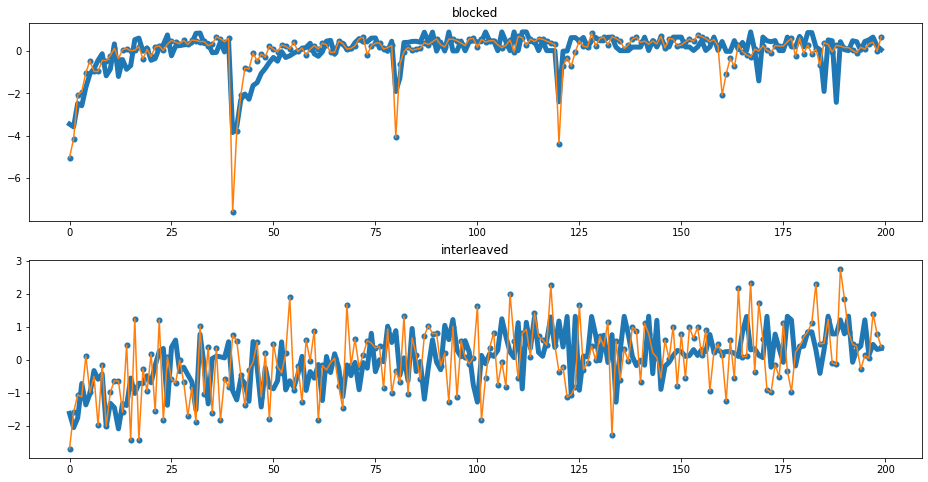

In [21]:
# z over time, mean over subjects
zacc_model = zscore(acc_best,axis=2).mean(1)[:,:,1] 
zacc_human = zscore(human_acc,axis=1) 



f,axar=plt.subplots(2,1,figsize=(16,8))

for i in range(2):
  axar[i].set_title(['blocked','interleaved'][i])
  Mac = acc_best[i].mean(0)
  axar[i].plot(zacc_model[i],lw=5)
  axar[i].plot(range(200),zacc_human[i])
  axar[i].scatter(range(200),zacc_human[i],lw=.05)



[Text(0, 0, 'human B'),
 Text(1, 0, 'model B'),
 Text(2, 0, 'human I'),
 Text(3, 0, 'model I')]

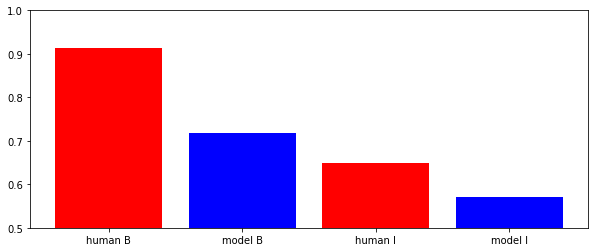

In [22]:
f,ax=plt.subplots(1,1,figsize=(10,4))
tstep = 1

#mean over subs and test trials
Btest_model = acc_best[0,:,-40:,1].mean() 
Itest_model = acc_best[1,:,-40:,1].mean() 
Btest_human = human_acc[0,-40:].mean()
Itest_human = human_acc[1,-40:].mean()

testacc = [Btest_human,Btest_model,Itest_human,Itest_model,]

# ax = axar[0]
ax.bar(range(4),testacc,color=['r','b','r','blue'])
ax.set_ylim(0.5,1)
ax.set_xticks(range(4))
ax.set_xticklabels(['human B','model B','human I','model I'])

